In [1]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
import torch.optim as optim

In [3]:
import matplotlib.pyplot as plt

In [16]:
class ConvAutoEncoder(nn.Module):
    def __init__(self,
                 input_size=(3,32,32),
                 layers_num=2,
                 conv_out_channels=(6, 6),
                 conv_kernel_size=(2, 3),
                 conv_stride=(2, 2),
                 conv_padding=(0,0),
                 activ_func=(F.relu, F.relu),
                 pool_kernel_size=(2, 1),
                 pool_stride=(1, 1),
                 pool_padding=(0,0)):
        self.input_size=input_size
        self.layers_num=layers_num
        self.conv_out_channels=conv_kernel_size
        self.conv_kernel_size=conv_kernel_size
        self.conv_stride=conv_stride
        self.conv_padding=conv_padding
        self.pool_kernel_size=pool_kernel_size
        self.pool_stride=pool_stride
        self.pool_padding=pool_padding
        self.conv_layers = []
        self.conv_layers_t = []
        self.pool_layers = []
        self.unpool_layers = []
        for i in range(self.layers_num):
            in_chan = self.input_size[0] if i==0 else self.conv_out_channels[i-1]
            args = (in_chan, self.conv_out_channels[i], \
                    self.conv_kernel_size[i], self.conv_stride[i], self.conv_padding[i])
            self.conv_layers = self.conv_layers + [nn.Conv2d(*args)]
            args[0] = args[1]
            args[1] = in_chan
            self.conv_layers_t = [nn.Conv2d(*args)] + self.conv_layers_t
            args = (self.pool_kernel_size, self.pool_stride, self.pool_padding)
            self.pool_layers = self.pool_layers + [nn.MaxPool2d(args)]
            self.unpool_layers = [nn.MaxUnpool2d(args)] + self.unpool_layers
        self.conv_layers = nn.ModuleList([]).extend(self.conv_layers)
        self.conv_layers_t = nn.ModuleList([]).extend(self.conv_layers_t)
        self.pool_layers = nn.ModuleList([]).extend(self.pool_layers)
        self.unpool_layers = nn.ModuleList([]).extend(self.unpool_layers)
        self.mode_fl = "learn" # learn or encode
    def forward(self,x):
        for i in range(self.layers_num):
            x = self.conv_layers[i](x)
            x = activ_func[i](x)
            x = self.pool_layers[i]
        if self.mode_fl == "encode":
            return x
        for i in range(self.layers_num):
            x = self.unpool_layers[i]
            x = activ_func[-i-1](x)  
            x = self.conv_layers_t[i](x)
        return x

In [17]:
class ConvNet(nn.Module):
    def __init__(self,
                 input_size=(3,32,32),
                 class_num = 2,
                 layers_num=2,
                 conv_out_channels=(6, 6),
                 conv_kernel_size=(2, 3),
                 conv_stride=(2, 2),
                 conv_padding=(0,0),
                 activ_func=(F.relu, F.relu),
                 pool_kernel_size=(2, 1),
                 pool_stride=(1, 1),
                 pool_padding=(0,0)):
        super(ConvNet, self).__init__()
        self.input_size=input_size
        self.class_num = class_num
        self.layers_num=layers_num
        self.conv_out_channels=conv_out_channels
        self.conv_kernel_size=conv_kernel_size
        self.conv_stride=conv_stride
        self.conv_padding=conv_padding
        self.activ_func=activ_func
        self.pool_kernel_size=pool_kernel_size
        self.pool_stride=pool_stride
        self.pool_padding=pool_padding
        self.conv_layers = []
        self.pool_layers = []
        self.history = []
        
        for i in range(self.layers_num):
            in_chan = self.input_size[0] if i==0 else self.conv_out_channels[i-1]
            args = (in_chan, self.conv_out_channels[i], \
                    self.conv_kernel_size[i], self.conv_stride[i], self.conv_padding[i])
            self.conv_layers = self.conv_layers + [nn.Conv2d(*args)]
            args = (self.pool_kernel_size[i], self.pool_stride[i], self.pool_padding[i])
            self.pool_layers = self.pool_layers + [nn.MaxPool2d(*args)]
        self.conv_layers = nn.ModuleList([]).extend(self.conv_layers)
        self.pool_layers = nn.ModuleList([]).extend(self.pool_layers)
        
        h_out = input_size[1]
        self.layer_out_list = [input_size[1]**2*input_size[0]]
        for i in range(self.layers_num):
            c_out = self.conv_out_channels[i-1] if i-1>0 else self.input_size[0]
            h_out = math.floor((h_out+2*self.conv_padding[i]-\
                                (self.conv_kernel_size[i]-1)-1)/self.conv_stride[i]+1)
            h_out = math.floor((h_out+2*self.pool_padding[i]-\
                                (self.pool_kernel_size[i]-1)-1)/self.pool_stride[i]+1)
            self.layer_out_list = self.layer_out_list + [h_out**2*self.conv_out_channels[i]]
        self.linear_in=self.conv_out_channels[-1] * h_out**2
        self.linear_layer = nn.Linear(self.linear_in, self.class_num)
    def forward(self,x):
        for i in range(self.layers_num):
            x = self.conv_layers[i](x)
            if self.activ_func:
                x = self.activ_func[i](x)
            x = self.pool_layers[i](x)
        x = self.linear_layer(x.view(-1, self.linear_in))
        return x

## Task №1

### Logistic regression Net

In [5]:
net = ConvNet(class_num=10,layers_num=1,conv_out_channels=(4,),\
              conv_kernel_size=(5,),conv_stride=(1,),conv_padding=(0,),activ_func=(),\
              pool_kernel_size=(2,),pool_stride=(1,),pool_padding=(0,))

In [20]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32),3),\
                                           torchvision.transforms.ToTensor(), \
                                           torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [21]:
trainset = torchvision.datasets.STL10('/media/alex/Windows8_OS/Ubuntu/python/sem_2',\
                           transform=transform)

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [22]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

NameError: name 'trainset' is not defined

In [9]:
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [12]:
criterion = nn.CrossEntropyLoss()

In [50]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

[1,   500] loss: 2.045
[1,  1000] loss: 1.921
[2,   500] loss: 1.708
[2,  1000] loss: 1.742
[3,   500] loss: 1.532
[3,  1000] loss: 1.593
[4,   500] loss: 1.381
[4,  1000] loss: 1.500
[5,   500] loss: 1.248
[5,  1000] loss: 1.443
[6,   500] loss: 1.127
[6,  1000] loss: 1.373
[7,   500] loss: 1.057
[7,  1000] loss: 1.171
[8,   500] loss: 1.026
[8,  1000] loss: 1.111
[9,   500] loss: 0.906
[9,  1000] loss: 1.063
[10,   500] loss: 0.800
[10,  1000] loss: 0.976
[11,   500] loss: 0.735
[11,  1000] loss: 0.976
[12,   500] loss: 0.634
[12,  1000] loss: 0.870
[13,   500] loss: 0.620
[13,  1000] loss: 0.776
[14,   500] loss: 0.572
[14,  1000] loss: 0.719
[15,   500] loss: 0.509
[15,  1000] loss: 0.682


In [10]:
testset = torchvision.datasets.STL10(root='/media/alex/Windows8_OS/Ubuntu/python/sem_2', split='test',\
                                     transform=transform)

In [11]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=2)

#### Result

In [53]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 36 %


### Random Forest

In [669]:
from sklearn.ensemble import RandomForestClassifier

In [670]:
rfclf = RandomForestClassifier(1000,n_jobs=-1)

In [671]:
import numpy as np

In [672]:
import sklearn

In [ ]:
X = np.ravel(trainset[0][0].numpy())
y = np.array(trainset[0][1])

for data in trainset:
    images, labels = data
    X = np.vstack((X,np.ravel(images.numpy())))
    y = np.vstack((y,np.array(labels)))

X = X[1::]
y = y[1::]

X,y = sklearn.utils.shuffle(X,y)

y = y.ravel()

In [63]:
rfclf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
X_test = np.ravel(trainset[0][0].numpy())
y_test = np.array(trainset[0][1])

In [65]:
for data in testset:
    images, labels = data
    X_test = np.vstack((X_test,np.ravel(images.numpy())))
    y_test = np.vstack((y_test,np.array(labels)))

In [66]:
X_test = X_test[1::]

In [67]:
y_test = y_test[1::]

In [68]:
y_pred = rfclf.predict(X_test)

#### Result

In [69]:
print("accuracy for random forest %d %%" % (100*(y_pred.ravel() == y_test.ravel()).sum()/y_test.shape[0]))

accuracy for random forest 43 %


## Task №2

#### functions

In [637]:
def fitNet(net, epoch_num=15, trainloader=trainloader, optimizer=optim.SGD, weight_decay=0.1, momentum=0):
    optimizer = optimizer(net.parameters(), lr=0.001, weight_decay=weight_decay, momentum = momentum)
    
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epoch_num):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]

def accuracy(net, testloader=testloader):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    return 100 * correct / total
    
def finder(kwargsbias, param_list, param_name):
    acc = []
    arg = []
    for i, par in enumerate(param_list):
        kwargsbias[param_name] = par
        net = ConvNet(**kwargsbias)        
        if(3*32*32 > net.linear_in):
            fitNet(net)
            acc = acc + [accuracy(net)] 
            arg = arg + [i]
        else:
            acc = acc + ['st']
            arg = arg + [i]
    return acc, arg

#### Kernel

In [71]:
params = {"class_num":10, "layers_num":1, "conv_out_channels":(5,),\
                "conv_kernel_size":(2,), "conv_stride":(1,), "conv_padding":(0,),\
                "activ_func":(), "pool_kernel_size":(2,), "pool_stride":(2,), "pool_padding":(0,)}

In [72]:
acc, arg = finder(params, [(i,) for i in range(2,9,1)], 'conv_kernel_size')

In [73]:
arg

[0, 1, 2, 3, 4, 5, 6]

In [74]:
acc

[39.5125, 41.025, 40.4625, 40.825, 40.1875, 39.8, 39.9]

#### filters num

In [75]:
acc, arg = finder(params, [(i,) for i in range(5,40,4)], 'conv_out_channels')

In [76]:
acc

[41.275, 40.075, 41.65, 42.05, 42.05, 'st', 'st', 'st', 'st']

In [77]:
[(i,) for i in range(5,40,4)]

[(5,), (9,), (13,), (17,), (21,), (25,), (29,), (33,), (37,)]

#### kernel + filter num

In [78]:
params = {"class_num":10, "layers_num":1, "conv_out_channels":(5,),\
                "conv_kernel_size":(4,), "conv_stride":(2,), "conv_padding":(0,),\
                "activ_func":(), "pool_kernel_size":(2,), "pool_stride":(1,), "pool_padding":(0,)}

In [79]:
acc, arg = finder(params, [(i,) for i in range(5,40,4)], 'conv_out_channels')

In [80]:
acc

[43.4125, 45.9, 45.5375, 'st', 'st', 'st', 'st', 'st', 'st']

In [81]:
[(i,) for i in range(5,40,4)]

[(5,), (9,), (13,), (17,), (21,), (25,), (29,), (33,), (37,)]

In [82]:
params.update({"conv_kernel_size":(6,)})

In [83]:
acc, arg = finder(params, [(i,) for i in range(5,40,4)], 'conv_out_channels')

In [84]:
acc

[42.5375, 45.6125, 45.95, 45.675, 'st', 'st', 'st', 'st', 'st']

In [85]:
params.update({"conv_kernel_size":(8,)})

In [86]:
acc, arg = finder(params, [(i,) for i in range(5,40,4)], 'conv_out_channels')

In [87]:
acc

[41.575, 43.0625, 45.275, 44.65, 45.6625, 'st', 'st', 'st', 'st']

In [89]:
params.update({"conv_kernel_size":(6,), "conv_out_channels":(13,)})

In [90]:
net = ConvNet(**params)

#### Result  
acc:45.9  
layers num:1  
kernel:6  
filter num: 13  

In [368]:
filt_list = list(range(5,40,4))

In [369]:
filt_list

[5, 9, 13, 17, 21, 25, 29, 33, 37]

([<matplotlib.axis.XTick at 0x7f9dda3bdac8>,
 <a list of 5 Text xticklabel objects>)

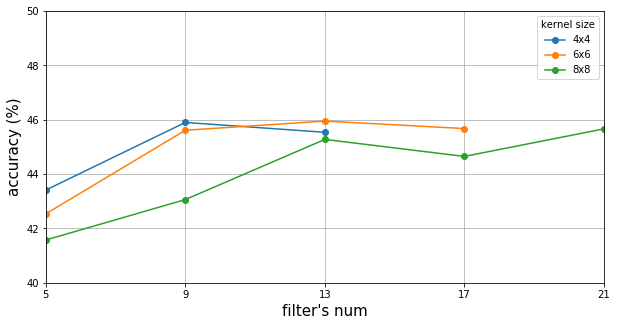

In [391]:
plt.figure(figsize=(10,5))
plt.plot(filt_list[0:3], [43.4125, 45.9, 45.5375],'-o', label='4x4')
plt.plot(filt_list[0:4], [42.5375, 45.6125, 45.95, 45.675],'-o',label='6x6')
plt.plot(filt_list[0:5], [41.575, 43.0625, 45.275, 44.65, 45.6625],'-o', label='8x8')
plt.legend(title="kernel size")
plt.grid()
plt.axis( [5,21,40,50],'tight')
plt.xlabel('filter\'s num', fontsize=15)
plt.ylabel('accuracy (%)', fontsize=15)
plt.xticks(filt_list[0:5])

#### layer 2

In [161]:
params = {"class_num":10, "layers_num":2, "conv_out_channels":[13,14],\
                "conv_kernel_size":[6,2], "conv_stride":(2,1), "conv_padding":(0,0),\
                "activ_func":(), "pool_kernel_size":(2,2), "pool_stride":(1,1), "pool_padding":(0,0)}

In [112]:
net = ConvNet(**params)

In [113]:
net.layer_out_list

[3072, 2197, 1694]

In [114]:
fitNet(net,30,trainloader,weight_decay=0.003)

In [115]:
accuracy(net)

49.0125

In [116]:
net_2 = ConvNet(**params)

In [117]:
net_2.layer_out_list

[3072, 2197, 1694]

In [660]:
f = lambda x: all([x[i]<x[i-1] for i in range(1, len(x))])

In [656]:
def layer_slayer(kwargsbias, param_list, param_name):
    acc = []
    arg = []
    for i, par in enumerate(param_list):
        kwargsbias[param_name][-1] = par
        net = ConvNet(**kwargsbias)
        print(net.layer_out_list)
        print(f(net.layer_out_list))
        if(f(net.layer_out_list)):
            fitNet(net, 15*net.layers_num, weight_decay=0.003)
            acc = acc + [accuracy(net)] 
            arg = arg + [par]
        else:
            acc = acc + ['st']
            arg = arg + [par]
    return acc, arg

In [144]:
params["conv_kernel_size"][-1]=2

In [145]:
layer_slayer(params, [i for i in range(13,41,4)], 'conv_out_channels')


[3072, 2197, 1573]
True
[3072, 2197, 2057]
True
[3072, 2197, 2541]
False
[3072, 2197, 3025]
False
[3072, 2197, 3509]
False
[3072, 2197, 3993]
False
[3072, 2197, 4477]
False


([48.025, 49.0875, 'st', 'st', 'st', 'st', 'st'], [0, 1, 2, 3, 4, 5, 6])

In [147]:
list(range(13,41,4))

[13, 17, 21, 25, 29, 33, 37]

In [155]:
params["conv_kernel_size"][-1]=3

In [162]:
layer_slayer(params, [i for i in range(13,41,4)], 'conv_out_channels')

[3072, 2197, 1573]
True
[3072, 2197, 2057]
True
[3072, 2197, 2541]
False
[3072, 2197, 3025]
False
[3072, 2197, 3509]
False
[3072, 2197, 3993]
False
[3072, 2197, 4477]
False


([49.675, 50.4125, 'st', 'st', 'st', 'st', 'st'], [13, 17, 21, 25, 29, 33, 37])

In [163]:
params["conv_kernel_size"][-1]=4

In [164]:
layer_slayer(params, [i for i in range(13,41,4)], 'conv_out_channels')

[3072, 2197, 1053]
True
[3072, 2197, 1377]
True
[3072, 2197, 1701]
True
[3072, 2197, 2025]
True
[3072, 2197, 2349]
False
[3072, 2197, 2673]
False
[3072, 2197, 2997]
False


([49.2625, 48.3625, 49.9375, 50.6125, 'st', 'st', 'st'],
 [13, 17, 21, 25, 29, 33, 37])

#### layer3

In [173]:
params = {"class_num":10, "layers_num":3, "conv_out_channels":[13,25,40],\
                "conv_kernel_size":[6,4,2], "conv_stride":(2,1,1), "conv_padding":(0,0,0),\
                "activ_func":(), "pool_kernel_size":(2,2,2), "pool_stride":(1,1,1), "pool_padding":(0,0,0)}

In [174]:
net = ConvNet(**params)

In [175]:
net.layer_out_list

[3072, 2197, 2025, 1960]

In [177]:
fitNet(net,60,weight_decay=0.001)

In [178]:
accuracy(net)

49.4625

#### Loss and Time

In [6]:
import json

In [13]:
from time import time

In [38]:
def loss_and_time(net, epoch_num=15, trainloader=trainloader, optimizer=optim.SGD,\
                  weight_decay=0.1, momentum=None, lr = 0.001):
    if momentum is not None:
        optimizer = optimizer(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    else:
        optimizer = optimizer(net.parameters(), lr=lr, weight_decay=weight_decay)
    start = time()
    time_list = [0]
    for epoch in range(epoch_num):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
            if(i % 500 == 499):
                time_list = time_list + [time() - start]
                net.history += [running_loss/500]
                running_loss = 0
    return time_list

NameError: name 'trainloader' is not defined

In [233]:
params = {"class_num":10, "layers_num":1, "conv_out_channels":(5,),\
                "conv_kernel_size":(4,), "conv_stride":(2,), "conv_padding":(0,),\
                "activ_func":(), "pool_kernel_size":(2,), "pool_stride":(1,), "pool_padding":(0,)}

In [234]:
net1 = ConvNet(**params)

In [281]:
params = {"class_num":10, "layers_num":2, "conv_out_channels":[13,25],\
                "conv_kernel_size":[6,4], "conv_stride":(2,1), "conv_padding":(0,0),\
                "activ_func":(), "pool_kernel_size":(2,2), "pool_stride":(1,1), "pool_padding":(0,0)}

In [282]:
net2 = ConvNet(**params)

In [283]:
params = {"class_num":10, "layers_num":3, "conv_out_channels":[13,25,40],\
                "conv_kernel_size":[6,4,2], "conv_stride":(2,1,1), "conv_padding":(0,0,0),\
                "activ_func":(), "pool_kernel_size":(2,2,2), "pool_stride":(1,1,1), "pool_padding":(0,0,0)}

In [284]:
net3 = ConvNet(**params)

In [334]:
params = {"class_num":10, "layers_num":4, "conv_out_channels":[13,25,40,40],\
                "conv_kernel_size":[6,4,2,2], "conv_stride":(2,1,1,1), "conv_padding":(0,0,0,0),\
                "activ_func":(), "pool_kernel_size":(2,2,2,1), "pool_stride":(1,1,1,1), "pool_padding":(0,0,0,0)}

In [335]:
net4 = ConvNet(**params)

In [336]:
net4.layer_out_list

[3072, 2197, 2025, 1960, 1440]

In [337]:
params = {"class_num":10, "layers_num":5, "conv_out_channels":[13,25,40,40,40],\
                "conv_kernel_size":[6,4,2,2,2], "conv_stride":(2,1,1,1,1), "conv_padding":(0,0,0,0,0),\
                "activ_func":(), "pool_kernel_size":(2,2,2,1,1), "pool_stride":(1,1,1,1,1),\
          "pool_padding":(0,0,0,0,0)}

In [338]:
net5 = ConvNet(**params)

In [339]:
net5.layer_out_list

[3072, 2197, 2025, 1960, 1440, 1000]

In [239]:
time1 = loss_and_time(net1,15,weight_decay=0.003)

In [285]:
time2 = loss_and_time(net2,15,weight_decay=0.003)

In [286]:
time3 = loss_and_time(net3,15,weight_decay=0.003)

In [340]:
time4 = loss_and_time(net4,15,weight_decay=0.003)

In [341]:
time5 = loss_and_time(net5,15,weight_decay=0.003)

In [7]:
f = open("exp_2_data", 'r')

In [343]:
data = {'time1':time1,
        'time2':time2,
        'time3':time3,
        'time4':time4,
        'time5':time5,
        'net1':net1.history ,
        'net2':net2.history,
        'net3':net3.history,
        'net4':net4.history,
        'net5':net5.history}

In [344]:
json.dump(data, f)

In [9]:
f.close()

In [8]:
data = json.load(f)

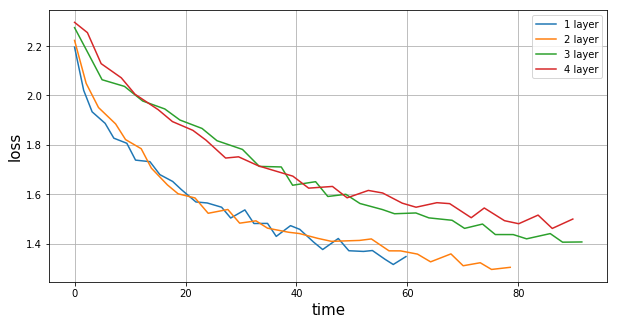

In [11]:

plt.figure(figsize=(10,5))
plt.plot(data['time1'][0:-1:], data['net1'], label='1 layer')
plt.plot(data['time2'][0:-1:], data['net2'], label='2 layer')
plt.plot(data['time3'][0:-1:], data['net3'],label='3 layer')
plt.plot(data['time4'][0:-1:], data['net4'],label='4 layer')
plt.legend()
plt.grid()
plt.xlabel('time', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.savefig('plot2.pdf', format='pdf')

#### Momentum strategy

In [12]:
params = {"class_num":10, "layers_num":2, "conv_out_channels":[13,25],\
                "conv_kernel_size":[6,4], "conv_stride":(2,1), "conv_padding":(0,0),\
                "activ_func":(), "pool_kernel_size":(2,2), "pool_stride":(1,1), "pool_padding":(0,0)}

In [13]:
net = ConvNet(**params)

In [37]:
time_list = []
history = []
for i in [0, 0.01, 0.1]:
    net = ConvNet(**params)
    time_list += [loss_and_time(net,15,weight_decay=0.003, momentum=i)]
    history += [net.history]

NameError: name 'loss_and_time' is not defined

In [410]:
time_list2 = []
history2 = []
for i in [0.5, 0.7]:
    net = ConvNet(**params)
    time_list2 += [loss_and_time(net,15,weight_decay=0.003, momentum=i)]
    history2 += [net.history]

In [36]:

plt.figure(figsize=(10,5))
plt.plot(time_list[0][0:-1:], history[0], label='0')
plt.plot(time_list[1][0:-1:], history[1],label='0.01')
plt.plot(time_list[2][0:-1:], history[2],label='0.1')
plt.plot(time_list2[0][0:-1:], history2[0],label='0.9')
plt.plot(time_list2[1][0:-1:], history2[1],label='0.7')
plt.legend(title='momentum:')
plt.grid()
plt.xlabel('time', fontsize=15)
plt.ylabel('loss', fontsize=15)

IndexError: list index out of range

### Optimizers

In [453]:
net_adam = ConvNet(**params)

In [454]:
time_adam = loss_and_time(net_adam, 15, optimizer=optim.Adam, lr=0.0001)

In [455]:
net_ada = ConvNet(**params)

In [456]:
time_ada = loss_and_time(net_ada, 15, optimizer=optim.Adagrad)

Text(0,0.5,'loss')

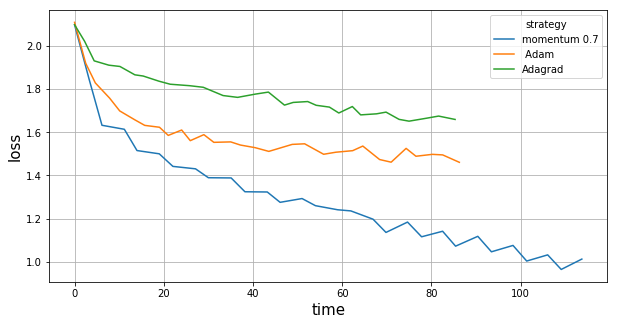

In [457]:
plt.figure(figsize=(10,5))
plt.plot(time_list2[1][0:-1:], history2[1],label='momentum 0.7')
plt.plot(time_adam[0:-1:], net_adam.history,label=' Adam')
plt.plot(time_ada[0:-1:], net_ada.history,label='Adagrad')
plt.legend(title='strategy')
plt.grid()
plt.xlabel('time', fontsize=15)
plt.ylabel('loss', fontsize=15)

## Experiment 3

In [32]:
import pickle

In [14]:
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (10000, rlimit[1]))

In [27]:
class ConvAutoEncoder(nn.Module):
    def __init__(self,
                 input_size=(3,32,32),
                 layers_num=2,
                 conv_out_channels=(6, 6),
                 conv_kernel_size=(2, 3),
                 conv_stride=(2, 2),
                 conv_padding=(0,0),
                 pool_kernel_size=(2, 1),
                 pool_stride=(1, 1),
                 pool_padding=(0,0)):
        super(ConvAutoEncoder, self).__init__()
        self.input_size=input_size
        self.layers_num=layers_num
        self.conv_out_channels=conv_out_channels
        self.conv_kernel_size=conv_kernel_size
        self.conv_stride=conv_stride
        self.conv_padding=conv_padding
        self.pool_kernel_size=pool_kernel_size
        self.pool_stride=pool_stride
        self.pool_padding=pool_padding
        self.conv_layers = []
        self.conv_layers_t = []
        self.pool_layers = []
        self.unpool_layers = []
        for i in range(self.layers_num):
            in_chan = self.input_size[0] if i==0 else self.conv_out_channels[i-1]
            args = [in_chan, self.conv_out_channels[i], \
                    self.conv_kernel_size[i], self.conv_stride[i], self.conv_padding[i]]
            self.conv_layers = self.conv_layers + [nn.Conv2d(*args)]
            args[0] = args[1]
            args[1] = in_chan
            self.conv_layers_t = [nn.ConvTranspose2d(*args)] + self.conv_layers_t
            args = (self.pool_kernel_size[i], self.pool_stride[i], self.pool_padding[i])
            self.pool_layers = self.pool_layers + [nn.MaxPool2d(*args, return_indices=True)]
            self.unpool_layers = [nn.MaxUnpool2d(*args)] + self.unpool_layers
        self.conv_layers = nn.ModuleList([]).extend(self.conv_layers)
        self.conv_layers_t = nn.ModuleList([]).extend(self.conv_layers_t)
        self.pool_layers = nn.ModuleList([]).extend(self.pool_layers)
        self.unpool_layers = nn.ModuleList([]).extend(self.unpool_layers)
        self.mode_fl = "learn" # learn or encode
        h_out = input_size[1]
        self.layer_out_list = [input_size[1]**2*input_size[0],(input_size[0],input_size[1],input_size[1])]
        for i in range(self.layers_num):
            c_out = self.conv_out_channels[i-1] if i-1>0 else self.input_size[0]
            h_out = math.floor((h_out+2*self.conv_padding[i]-\
                                (self.conv_kernel_size[i]-1)-1)/self.conv_stride[i]+1)
            h_out = math.floor((h_out+2*self.pool_padding[i]-\
                                (self.pool_kernel_size[i]-1)-1)/self.pool_stride[i]+1)
            self.layer_out_list = self.layer_out_list + [h_out**2*self.conv_out_channels[i],\
                                                         (self.conv_out_channels[i],h_out,h_out)]
    def forward(self,x):
        indices_list = []
        size_list = []
        for i in range(self.layers_num):
            size_list = [x.size()] + size_list 
            x = self.conv_layers[i](x)
            x = F.relu(x)
            x, indices = self.pool_layers[i](x)
            indices_list = [indices] + indices_list
        if self.mode_fl == "encode":
            return x
        for i in range(self.layers_num):
            x = self.unpool_layers[i](x, indices_list[i])   
            x = self.conv_layers_t[i](x, output_size=size_list[i])
            x = F.tanh(x)  
        return x

In [35]:
unlabeled = torchvision.datasets.STL10(root='/media/alex/Windows8_OS/Ubuntu/python/sem_2', split='unlabeled',\
                                     transform=transform)

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [17]:
unlabeledloader = torch.utils.data.DataLoader(unlabeled, batch_size=4,
                                          shuffle=True, num_workers=2)

In [18]:
def fitAutoCoder(net, epoch_num=15, trainloader=trainloader, optimizer=optim.SGD,\
                  weight_decay=0.1, momentum=None, lr = 0.001):
    if momentum is not None:
        optimizer = optimizer(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    else:
        optimizer = optimizer(net.parameters(), lr=lr, weight_decay=weight_decay)
    start = time()
    time_list = [0]
    for epoch in range(epoch_num):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

In [19]:
criterion = nn.MSELoss()

In [61]:
auto_code_net = ConvAutoEncoder()

In [21]:
auto_code_net.layer_out_list

[3072, (3, 32, 32), 1350, (6, 15, 15), 294, (6, 7, 7)]

In [62]:
fitAutoCoder(auto_code_net)

In [57]:
save_net(auto_code_net, 'auto_code_net')

In [29]:
def save_net(net, filename):
    f = open(filename, 'wb')
    cache_dict = dict(net.named_children())
    pickle.dump(cache_dict, f)
    f.close()

In [30]:
def load_net(net, filename):
    f = open(filename, 'rb')
    cache_dict = pickle.load(f)
    for it in net.named_children():
        if(type(cache_dict[it[0]]) == nn.ModuleList):
            for i, modul in enumerate(cache_dict[it[0]], 0):
                if(type(modul) != nn.MaxPool2d and type(modul) != nn.MaxUnpool2d):
                    it[1][i].weight.data = modul.weight.data
                    it[1][i].bias.data = modul.bias.data
        else:
            modul[1].weight.data = cache_dict[it[0]].weight.data
            modul[1].bias.data = cache_dict[it[0]].bias.data
    f.close()

In [96]:
def MSE_counter(net, testloader=testloader):
    coef = testloader.dataset.data.shape[0]/testloader.batch_size
    summ = 0
    criterion = nn.MSELoss()
    for data in testloader:
        images, _ = data
        images = Variable(images)
        #print(criterion(net(images),images).data[0])
        summ = summ + criterion(net(images),images).data[0]
    return summ/coef

In [97]:
MSE_counter(auto_code_net)

0.24960090845823288

#### try parameters

|№|conv_out_channels|conv_kernel_size|conv_stride|conv_padding|pool_kernel_size|pool_stride|pool_padding|momentum|MSE|
|--|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|1| 6| 2| 2| 0| 2|1 | 0|0| 0.1494|
|2| -| 3| -| -| -|-|-|-| 0.1137|
|3!| -| 4|-|-|-|-|-|-| 0.0922|
|4| -| 5|-|-|-|-|-|-|0.1126|
|5| 7| 4|-|-|-|-|-|-|0.0917|
|6| -| -|-|1|-|-|-|-|0.0705|
|7|-|-|-|2|-|-|-|-|0.0628|
|8|-|-|-|3|-|-|-|-|0.0570|
|9|-|8|-|6|-|-|-|-|0.0451|
|10|-|-|-|-|-|-|-|0.7|0.0310|
|11|-|-|-|-|-|-|-|0.95|0.0214|

#1

In [107]:
net.layer_out_list

[3072, (3, 32, 32), 1350, (6, 15, 15)]

#2

In [112]:
net.layer_out_list

[3072, (3, 32, 32), 1176, (6, 14, 14)]

#3

In [117]:
net.layer_out_list

[3072, (3, 32, 32), 1176, (6, 14, 14)]

#4

In [25]:
params = {'input_size':(3,32,32),'layers_num':1,\
    'conv_out_channels':(7,),'conv_kernel_size':(8,),'conv_stride':(2,),'conv_padding':(6,),\
                 'pool_kernel_size':(2, ),'pool_stride':(1, ),'pool_padding':(0,)}

In [28]:
net = ConvAutoEncoder(**params)

In [446]:
net.layer_out_list

[3072, (3, 32, 32), 2268, (7, 18, 18)]

In [72]:
testloader.dataset.data.shape[0]

8000

In [453]:
fitAutoCoder(net, 15, weight_decay=0.003, momentum=0.95, lr=0.0005)

In [454]:
MSE_counter(net)

0.01968281058827415

In [95]:
0.06240022714063525 * 4 * 32 * 32 * 3

766.7739911041259

In [60]:
 import garbage_collector as gc

ImportError: No module named 'garbage_collector'

In [455]:
save_net(net, "autoencoder")

In [33]:
load_net(net, "autoencoder")

In [34]:
net.mode_fl

'learn'

In [ ]:

    net()

## Experiment 4


In [456]:
net.mode_fl = 'encode'

In [461]:
net.layer_out_list

[3072, (3, 32, 32), 2268, (7, 18, 18)]

In [485]:
params = {'input_size':(7, 18, 18),"class_num":10, "layers_num":1, "conv_out_channels":(13,),\
                "conv_kernel_size":(6,), "conv_stride":(1,), "conv_padding":(0,),\
                "activ_func":(), "pool_kernel_size":(2,), "pool_stride":(1,), "pool_padding":(0,)}

In [486]:
simple_net = ConvNet(**params)

In [487]:
simple_net.layer_out_list

[2268, 1872]

In [559]:
def fitNetEncode(net, encoder, epoch_num=15, trainloader=trainloader, optimizer=optim.SGD, weight_decay=0.1):
    
    optimizer = optimizer(net.parameters(), lr=0.001, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)
            
            inputs = encoder(inputs)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [545]:
def accuracyEncode(net, encoder, testloader=testloader):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        inputs = encoder(Variable(images))
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    return 100 * correct / total

In [482]:
fitNetEncode(simple_net, net, weight_decay=0.03)

In [484]:
accuracyEncode(simple_net, net)

45.7625

In [529]:
def finderEncode(kwargsbias, encoder, param_list, param_name):
    acc = []
    arg = []
    for i, par in enumerate(param_list):
        kwargsbias[param_name] = par
        net = ConvNet(**kwargsbias) 
        if(net.layer_out_list[0] > net.linear_in):
            fitNetEncode(net, encoder)
            acc = acc + [accuracyEncode(net, encoder)] 
            arg = arg + [i]
        else:
            acc = acc + ['st']
            arg = arg + [i]
    return acc, arg

In [601]:
params = {'input_size':(7, 18, 18),"class_num":10, "layers_num":1, "conv_out_channels":(35,),\
                "conv_kernel_size":(6,), "conv_stride":(2,), "conv_padding":(1,),\
                "activ_func":(), "pool_kernel_size":(2,), "pool_stride":(1,), "pool_padding":(0,)}

In [602]:
simple_net = ConvNet(**params)

In [603]:
fitNetEncode(simple_net,net,30,weight_decay=0.003)

In [604]:
accuracyEncode(simple_net,net)

49.95

In [457]:
checker = ConvAutoEncoder(**params)

In [585]:
simple_net.layer_out_list

[2268, 1715]

In [543]:
finderEncode(params, net, [(i,) for i in range(29,41)], 'conv_out_channels')

([45.1875,
  46.0875,
  45.1125,
  45.5375,
  45.2625,
  45.6875,
  46.1125,
  44.85,
  44.75,
  43.6875,
  45.7125,
  45.1125],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [532]:
[(i,) for i in range(5,40,4)]

[(5,), (9,), (13,), (17,), (21,), (25,), (29,), (33,), (37,)]

In [546]:
[(i,) for i in range(29,41)]

[(29,),
 (30,),
 (31,),
 (32,),
 (33,),
 (34,),
 (35,),
 (36,),
 (37,),
 (38,),
 (39,),
 (40,)]

In [458]:
load_net(checker, "autoencoder")

In [ ]:
layer_slayer_encoder(params, [i for i in range(5,40,4)], 'conv_out_channels', net)

In [675]:
net.mode_fl

'encode'

In [704]:
X = np.zeros((1,7*18*18))
y = np.array(trainset[0][1])

for data in trainloader:
    images, labels = data
    images = net(Variable(images)).data.numpy()
    for i in range(4):
        X = np.vstack((X, images[i].ravel()))
        y = np.vstack((y,np.array(labels[i])))

X = X[1::]
y = y[1::]

print(X.shape)


(5000, 2268)


In [705]:
X,y = sklearn.utils.shuffle(X,y)

y = y.ravel()

In [706]:
rfclf = RandomForestClassifier(1000,n_jobs=-1)

In [707]:
rfclf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [708]:
X_test = np.zeros((1,7*18*18))
y_test = np.array(testset[0][1])

for data in testloader:
    images, labels = data
    images = net(Variable(images)).data.numpy()
    for i in range(4):
        X_test = np.vstack((X_test, images[i].ravel()))
        y_test = np.vstack((y_test,np.array(labels[i])))

X_test = X_test[1::]
y_test = y_test[1::]

print(X_test.shape)

(8000, 2268)


In [711]:
X.shape

(5000, 2268)

In [709]:
y_pred = rfclf.predict(X_test)

In [724]:
y_test.ravel().shape

(8000,)

In [725]:
(y_test.ravel() == y_pred).sum()/y_test.shape[0]

0.48375

## Experiment 5

In [658]:
params = {'input_size':(3,32,32),"class_num":10,'layers_num':2,\
    'conv_out_channels':[7,35],'conv_kernel_size':(8,6),'conv_stride':(2,2),'conv_padding':(6,1),\
                 "activ_func":(), 'pool_kernel_size':(2,2),'pool_stride':(1, 1),'pool_padding':(0,0)}

In [650]:
fine_net = ConvNet(**params)

In [651]:
fine_net.layer_out_list

[3072, 2268, 1715]

In [652]:
fine_net.conv_layers[0].weight.data = net.conv_layers[0].weight.data

In [653]:
fine_net.conv_layers[0].bias.data = net.conv_layers[0].bias.data

In [654]:
fitNet(fine_net, 20, weight_decay=0.003)

In [655]:
accuracy(fine_net)

50.575

In [666]:
def layer_slayer_encoder(kwargsbias, param_list, param_name, encoder):
    acc = []
    arg = []
    for i, par in enumerate(param_list):
        kwargsbias[param_name][-1] = par
        net = ConvNet(**kwargsbias)
        net.conv_layers[0].weight.data = encoder.conv_layers[0].weight.data
        net.conv_layers[0].bias.data = encoder.conv_layers[0].bias.data
        print(net.layer_out_list)
        print(f(net.layer_out_list))
        if(f(net.layer_out_list)):
            fitNet(net, 20, weight_decay=0.003)
            acc = acc + [accuracy(net)] 
            arg = arg + [par]
        else:
            acc = acc + ['st']
            arg = arg + [par]
    return acc, arg

In [667]:
layer_slayer_encoder(params, [i for i in range(5,40,4)], 'conv_out_channels', net)

[3072, 2268, 245]
True
[3072, 2268, 441]
True
[3072, 2268, 637]
True
[3072, 2268, 833]
True
[3072, 2268, 1029]
True
[3072, 2268, 1225]
True
[3072, 2268, 1421]
True
[3072, 2268, 1617]
True
[3072, 2268, 1813]
True


([49.6625, 50.15, 51.2, 51.6125, 51.9875, 51.5, 50.7125, 50.4625, 51.7125],
 [5, 9, 13, 17, 21, 25, 29, 33, 37])

In [668]:
layer_slayer_encoder(params, [i for i in range(18,25,1)], 'conv_out_channels', net)

[3072, 2268, 882]
True
[3072, 2268, 931]
True
[3072, 2268, 980]
True
[3072, 2268, 1029]
True
[3072, 2268, 1078]
True
[3072, 2268, 1127]
True
[3072, 2268, 1176]
True


([50.7, 50.6375, 51.55, 50.5125, 50.6, 49.7125, 51.0],
 [18, 19, 20, 21, 22, 23, 24])

In [629]:
accuracyEncode(fine_net,net)

49.95

In [628]:
fine_net.linear_layer.bias.data = simple_net.linear_layer.bias.data

In [627]:
fine_net.conv_layers[0].bias.data = simple_net.conv_layers[0].bias.data

In [626]:
fine_net.linear_layer.weight.data = simple_net.linear_layer.weight.data

In [623]:
fine_net.conv_layers[0].weight.data = simple_net.conv_layers[0].weight.data

In [614]:
for name, mod in fine_net.named_children():
    print(name)

conv_layers
pool_layers
linear_layer


In [621]:
params = {'input_size':(7, 18, 18),"class_num":10, "layers_num":1, "conv_out_channels":(35,),\
                "conv_kernel_size":(6,), "conv_stride":(2,), "conv_padding":(1,),\
                "activ_func":(), "pool_kernel_size":(2,), "pool_stride":(1,), "pool_padding":(0,)}

In [619]:
fine_net.conv_layers_t[0].weight.data = net.conv_layers_t[0].weight.data

AttributeError: 'ConvNet' object has no attribute 'conv_layers_t'

In [526]:
fitNetEncode(simple_net, auto_code_net)

RuntimeError: Given groups=1, weight[5, 7, 6, 6], so expected input[4, 3, 32, 32] to have 7 channels, but got 3 channels instead

In [459]:
MSE_counter(checker)

0.019682810646947473